### Artificial Neural Network from Scratch

Implement a neural network with NumPy using binary classification. 

In [29]:
import numpy as np
import sklearn
import sklearn.datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
import pandas as pd
import plotly.express as px
import time
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (5.0, 4.0)

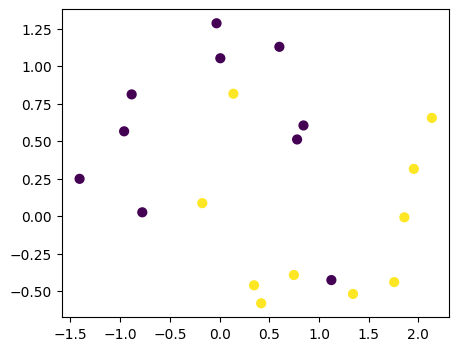

In [61]:
# Generate dataset
# We use the simple toy dataset sklearn.datasets.make_moons.
# The function has the following parameters: 1) n_samples: Total number of generated points; 
# 2) noise: Standard deviation of Gaussian noise added to the data
# 3) random_state: Seed for reproducible output

n = 20
data_seed = 4242   # choose seed value

X, y = sklearn.datasets.make_moons(
    n_samples = n, 
    noise = 0.25, 
    random_state = data_seed)

plt.scatter(
    x = X[:,0], 
    y = X[:,1], 
    s = 40,   # marker size 
    c = y)    # color by 

In [62]:
X,y

(array([[-0.88416012,  0.81152868],
        [-0.96002879,  0.56556449],
        [ 1.85874063, -0.00733803],
        [ 0.00764831,  1.05233801],
        [ 0.41849945, -0.5799713 ],
        [ 0.13869329,  0.81585066],
        [ 1.34215458, -0.51790117],
        [ 1.75641418, -0.43888248],
        [-0.77740569,  0.02605077],
        [-0.03057186,  1.28527143],
        [ 1.95392449,  0.31548605],
        [-1.40805091,  0.24901532],
        [ 0.60149834,  1.12853398],
        [-0.17373403,  0.08702362],
        [ 0.77983706,  0.5113426 ],
        [ 1.12450899, -0.42540832],
        [ 0.84391719,  0.6046485 ],
        [ 0.34686366, -0.46010923],
        [ 2.13531694,  0.65504985],
        [ 0.74766545, -0.39166277]]),
 array([0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1],
       dtype=int64))

In [63]:
# Split the dataset
#use the train_test_split() function of the sklearn package to create 
# our training and test dataset with labels
# The function has the following parameters: 1) X: The moons dataset, 
# 2) y: The labels; 3) test_size: Size of the test dataset in percent
# 4) random_size: Seed for reproducible output

test_size = 0.25
split_seed = 42 # choose split seed value

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = test_size,
    random_state = split_seed)

In [64]:
#  Define helper functions
# activation function (sigmod) and the derivation function (sigmod')
# The function sigmoid(z, derivation=FALSE) calculates for a value x 
# the result for the sigmoid or the derivation of the sigmoid.
def sigmoid(z, derivation = False):
    if derivation:
        return sigmoid(z)*(1-sigmoid(z))
    else:
        return 1/(1+np.exp(-z))

# cost function (Mean squared error function)
# In the function calculate_loss(), we calculate the squared error function. 
def calculate_loss(model, X, y):    
    # extract model parameters
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']

    # calculation of the estimated class probabilities
    ## calc hidden layer
    a1 = X.dot(W1) + b1
    h1 = sigmoid(a1)

    ## calc output layer
    a2 = h1.dot(W2) + b2
    probs = sigmoid(a2)[:,0]
    
    # calculation of the cost function value
    cost = np.power(y-probs,2)
    cost = np.sum(cost)/2

    return cost

# predict function
# In the predict function, we perform feed-forward propagation.
def predict(
        model, 
        x,
        proba = False,
        decision_point = 0.5):
    
    # extract model parameters
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']

    # calculation of the estimated class probabilities (Forward Propagation)
    ## calc hidden layer
    a1 = x.dot(W1) + b1
    h1 = sigmoid(a1)

    ## calc output layer
    a2 = h1.dot(W2) + b2
    probs = sigmoid(a2)
    
    if(proba):
        return probs

    return (probs>decision_point)*1

In [65]:
# Modeling
# Design our neural network.We create a network with only one hidden layer. 
# The function build_neural_network() receives as input variables our training data X_train,
# the labels y_train, the number of gradient descent iterations, the learning_rate, 
# a seed for reproducibility, the number of hidden nodes, and a value for initialising the weights.

def build_neural_network(
        X,                              # features
        y,                              # target
        iterations = 20000,             # number of gradient descent iterations
        learning_rate = 0.1,            # learning rate of Gradient descent
        random_state = None,            # random seed of weights 
        hidden_nodes = 5,               # number of hidden nodes
        rand_range = 0.05):             # initialise the weights

    observations = X.shape[0] # number of observations
    features = X.shape[1] # number of features

# initialise the parameters to random values:
    np.random.seed(random_state)
    W1 = np.random.uniform(low = -rand_range, 
                       high = rand_range, 
                       size= (features,hidden_nodes)) # (2,10)
    b1 = np.zeros((1,hidden_nodes))   # (1,10)

    W2 = np.random.uniform(low = -rand_range, 
                       high = rand_range, 
                       size= (hidden_nodes,1)) # (10, 1)
    b2 = np.zeros((1,1))   # (1,1)

# this is what we return at the end
    model = {}

# Gradient descent:
    for i in range(0, iterations):
    # Forward propagation
    ## calc hidden layer
        a1 = X.dot(W1) + b1   # X: (750, 2), W1: (2,10), a1: (750, 10)
        h1 = sigmoid(a1)   # z1: (750, 10)
    
    ## calc output layer
        a2 = h1.dot(W2) + b2   # z1: (750, 10), W2: (10, 1), a2: (750, 1)
        probs = sigmoid(a2)   # probs: (750, 1)

    # Backpropagation     
    # y.reshape: (750,1), probs: (750, 1), delta1: (750, 1)
        delta1 = (probs-y.reshape((observations,1))) * probs * (1 - probs)   # g(a_k)*(1-g(a_k))*(g(a_k)-t_k^n)
   
        dW2 = np.dot(h1.T, delta1)   # z1.T: (10, 750), delta1: (750,1), dW2: (10,1)
        db2 = np.sum(delta1, axis=0, keepdims=True)  # delta1: (750,1), db2: (1, 1)
    
        delta_j = delta1 * W2.T * h1 * (1 - h1)   # delta1: (750,1), W2.T: (1,10), z1: (750,10), delta_j: (750,10)

        dW1 = np.dot(X.T, delta_j)   # X.T: (2, 750), delta_j: (750,10), dW1: (750,1)
        db1 = np.sum(delta_j, axis=0) # delta_j: (750,10), db1: (10,1)

    # Gradient descent parameter update
        W1 += -learning_rate * dW1  # dW1: (750,1) 
  
        b1 += -learning_rate * db1  # db1: (10,1)
    
        W2 += -learning_rate * dW2
        b2 += -learning_rate * db2
    
    # assign new parameters to the model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
    
        if i % 100 == 0:
            print("Loss after iteration %7d:\t%f" %(i, calculate_loss(model,X,y)))
    return model

# Train the neural network
    model = build_neural_network(X = X_train,
                    y = y_train, 
                    iterations = 20000,
                    random_state = 4242,
                    hidden_nodes = 5,
                    learning_rate = 0.1,
                    rand_range = 0.1)


In [66]:
# Evaluation
# Classification Report.
# The trained neural network has a weighted avg recall and precision of ¿?. 
from sklearn.metrics import classification_report

predictions = predict(model, X_test)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.50      1.00      0.67         1

    accuracy                           0.80         5
   macro avg       0.75      0.88      0.76         5
weighted avg       0.90      0.80      0.82         5



In [67]:
#Experiments
# Default Setup for every experiment
# Gradient descent iterations: 10000
# hidden nodes: 5
# learning rate: 0.1

model = build_neural_network(X = X_train,
                    y = y_train, 
                    iterations = 10000,
                    random_state = 4242,
                    hidden_nodes = 5,
                    learning_rate = 0.1,
                    rand_range = 0.1)

Loss after iteration       0:	1.875586
Loss after iteration     100:	1.517456
Loss after iteration     200:	0.882122
Loss after iteration     300:	0.766919
Loss after iteration     400:	0.727978
Loss after iteration     500:	0.706837
Loss after iteration     600:	0.692045
Loss after iteration     700:	0.680054
Loss after iteration     800:	0.669481
Loss after iteration     900:	0.659715
Loss after iteration    1000:	0.650462
Loss after iteration    1100:	0.641578
Loss after iteration    1200:	0.632998
Loss after iteration    1300:	0.624699
Loss after iteration    1400:	0.616685
Loss after iteration    1500:	0.608974
Loss after iteration    1600:	0.601588
Loss after iteration    1700:	0.594547
Loss after iteration    1800:	0.587870
Loss after iteration    1900:	0.581567
Loss after iteration    2000:	0.575643
Loss after iteration    2100:	0.570097
Loss after iteration    2200:	0.564921
Loss after iteration    2300:	0.560105
Loss after iteration    2400:	0.555632
Loss after iteration    2

Source:

https://hub.tinztwins.de/p/understand-and-implement-an-artificial

Example. Real data

In [103]:
data=np.array([[-1.78,  -1.71],
        [-0.86,  0.66],
        [ 1.95, -0.073],
        [ 0.76,  1.15],
        [ 0.71, 1.97]])
data

array([[-1.78 , -1.71 ],
       [-0.86 ,  0.66 ],
       [ 1.95 , -0.073],
       [ 0.76 ,  1.15 ],
       [ 0.71 ,  1.97 ]])

In [104]:
p=predict(model, data)
p

array([[1],
       [0],
       [1],
       [0],
       [0]])

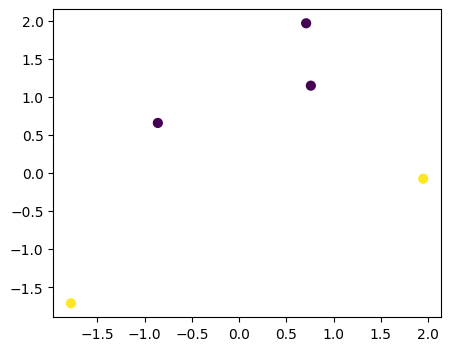

In [105]:
plt.scatter(
    x = data[:,0], 
    y = data[:,1], 
    s = 40,   # marker size 
    c = p)    # color by 